In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [3]:
df = ak.from_parquet("jets_combinations_ttHbb_fullymatched_v2.parquet")

In [4]:
(jets_fullymatched,  # initial collections of jets, already fully matched
comb_index,          # indices of jets with all the combinations for all the events
signal_comb,         # mask to get the "signal" combination  [events, True/False]
jets_combinations,   # collections of jets, many different collections for each event (from comb_index)
higgs_jets,          # higgs_jets (index 0, 1 of the combination)
tlep_jets,           # tlep jet (index 2 of the combination)
thad_jets,           # thad jets (index 3,4,5 of the combination)
whad_jets            # whad_jets (index 4 5 of the combination)
) = ak.unzip(df)

jets_combinations = ak.with_name(jets_combinations, name="Momentum4D")
higgs_jets = ak.with_name(higgs_jets, name="Momentum4D")
tlep_jets = ak.with_name(tlep_jets, name="Momentum4D")
thad_jets = ak.with_name(thad_jets, name="Momentum4D")
whad_jets = ak.with_name(whad_jets, name="Momentum4D")

In [5]:
jets_signal = ak.flatten(jets_combinations[signal_comb], axis=1)

In [27]:
def to_flat_numpy(X, fields, axis=1, allow_missing=False):
    return np.stack([ak.to_numpy(X[f], allow_missing=allow_missing) for f in fields], axis=axis)

def to_flat_tensor(X, fields, axis=1, allow_missing=False):
    return torch.tensor(np.stack([ak.to_numpy(X[f], allow_missing=allow_missing) for f in fields], axis=axis))


In [28]:
to_flat_numpy(jets_signal[0], ["pt","eta","phi", "btag"])

array([[ 4.25625000e+01,  7.23876953e-01,  3.02441406e+00,
         9.98046875e-01],
       [ 1.26000000e+02,  2.36523438e+00, -2.85644531e+00,
         9.96093750e-01],
       [ 8.43750000e+01,  2.15576172e+00,  1.50146484e+00,
         1.91406250e-01],
       [ 1.02437500e+02,  1.11718750e+00, -8.15795898e-01,
         9.99511719e-01],
       [ 1.41500000e+02,  1.50024414e+00,  1.18139648e+00,
         6.28280640e-03],
       [ 1.23812500e+02,  1.67382812e+00,  4.42382812e-01,
         6.17599487e-03]])

In [31]:
t = to_flat_tensor(jets_signal[0], ["pt","eta","phi", "btag"])

# PyTorch geometric dataset

In [53]:
import os

import numpy as np
import uproot
import torch
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import NormalizeFeatures
import torch.nn.functional as F
import awkward as ak
from tqdm import tqdm

In [96]:
class EventTaggingDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        
        
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.root + '/jets_combinations_ttHbb_fullymatched_v2.parquet']

    @property
    def processed_file_names(self):
        return [self.root + '/jets_combinations_ttHbb_fullymatched_v2.pt']


    def process(self):
        # Read data into huge `Data` list.
        data_list = []
        fields = ["pt","eta","phi","btag"]
        for file in self.raw_file_names:
            df = ak.from_parquet(file)
            jets = df.jets_fullymatched
            
            for i_ev in tqdm(range(len(jets))):
                njets = len(jets[i_ev])
                nodes_feat = to_flat_tensor(jets[i_ev], fields)
                E =  np.ones((njets, njets))
                np.fill_diagonal(E, 0)
                edge_index = torch.tensor(np.stack(np.where(E)))
                prov = ak.to_numpy(jets[i_ev].prov) -1
                np.place(prov, prov==-2, 4)
                y = F.one_hot(torch.tensor(prov, dtype=int), num_classes=5)
                
                data_list.append(
                    Data(
                        x=nodes_feat,
                        edge_index=edge_index,
                        num_nodes=njets,
                        num_node_features=nodes_feat.shape[1],
                        y=y
                    )
                )
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [97]:
data = EventTaggingDataset(".")

Processing...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67876/67876 [02:40<00:00, 423.21it/s]
Done!


In [102]:
from torch_geometric.loader import DataLoader
training_df = DataLoader(data, batch_size=100, shuffle=True)

In [105]:
for df in training_df:
    break

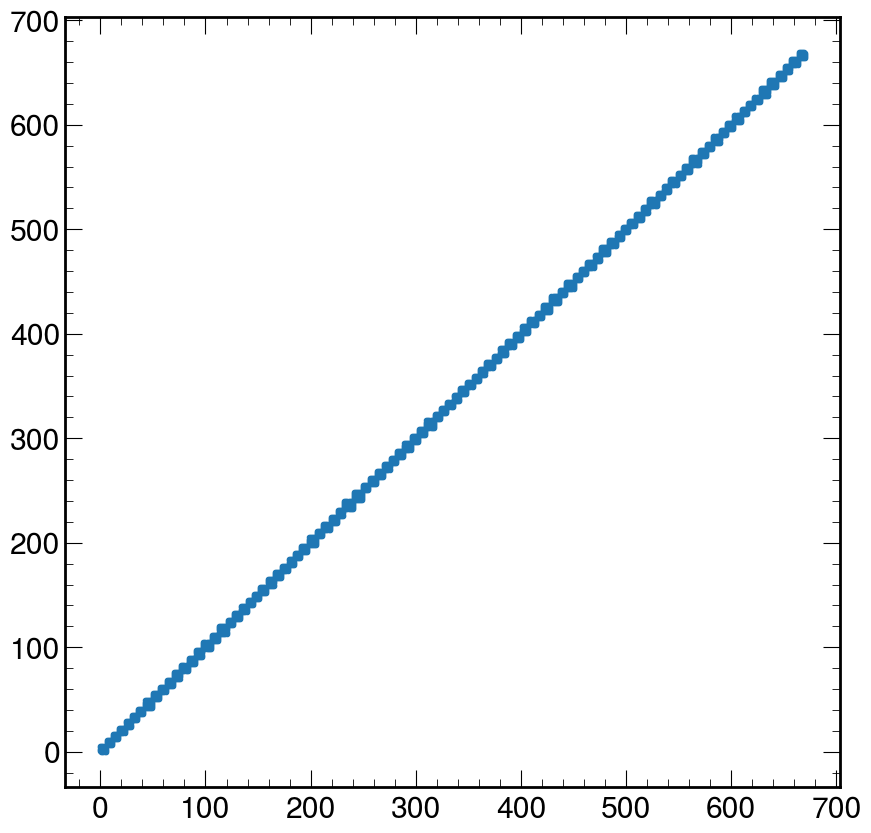

In [117]:
plt.scatter(df.edge_index[0],df.edge_index[1],marker='.')

In [123]:
df[0].is_undirected()

True

In [124]:
df

DataBatch(x=[671, 4], edge_index=[2, 3890], y=[671, 5], num_node_features=[100], num_nodes=671, batch=[671], ptr=[101])

In [197]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        print(x[0:3])
        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        print(x[0:3])

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        print(edge_index)
        print(norm)
        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_i, x_j, norm):
        # x_j has shape [E, out_channels]
        print(x_i[0:10])
        print(x_j[0:10])
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_i

In [202]:
gcn= GCNConv(4, 6)

In [203]:
single_df = data[0]

In [204]:
y = gcn.forward(single_df.x, single_df.edge_index)

tensor([[ 1.4150e+02,  1.5002e+00,  1.1814e+00,  6.2828e-03],
        [ 1.2600e+02,  2.3652e+00, -2.8564e+00,  9.9609e-01],
        [ 1.2381e+02,  1.6738e+00,  4.4238e-01,  6.1760e-03]])
tensor([[ 20.9799,  52.8095, -17.4519, -30.1470,  -1.8483, -66.7642],
        [ 19.6724,  49.3646, -16.8348, -25.4185,  -0.8666, -59.0206],
        [ 18.5045,  46.5402, -15.4916, -26.1895,  -1.4759, -58.3257]],
       grad_fn=<SliceBackward0>)
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 5, 5, 5, 5, 5, 0, 1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 0, 1, 2, 4, 5, 0, 1, 2, 3,
         5, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5]])
tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
        0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
        0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667,
        0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.

tensor([[  3.4967,   8.8016,  -2.9086,  -5.0245,  -0.3080, -11.1274],
        [  3.2787,   8.2274,  -2.8058,  -4.2364,  -0.1444,  -9.8368],
        [  3.0841,   7.7567,  -2.5819,  -4.3649,  -0.2460,  -9.7210],
        [  2.6002,   6.5628,  -2.1963,  -3.5195,  -0.1905,  -8.0301],
        [  2.0335,   5.2321,  -1.7564,  -3.0368,  -0.2630,  -6.5949],
        [  0.9132,   2.5101,  -0.8061,  -1.6301,  -0.2948,  -3.3387]],
       grad_fn=<AddBackward0>)

In [146]:
y[df.batch==0]

tensor([[ 0.7772, -1.2238, -0.9028, -1.2026,  0.0569],
        [ 0.7772, -1.2238, -0.9028, -1.2026,  0.0569],
        [ 0.7772, -1.2238, -0.9028, -1.2026,  0.0569],
        [ 0.7772, -1.2238, -0.9028, -1.2026,  0.0569],
        [ 0.7772, -1.2238, -0.9028, -1.2026,  0.0569],
        [ 0.7772, -1.2238, -0.9028, -1.2026,  0.0569]],
       grad_fn=<IndexBackward0>)

In [147]:
y[df.batch==1]

tensor([[ 1.1382, -1.7741, -1.3945, -1.7686, -0.0378],
        [ 1.1382, -1.7741, -1.3945, -1.7686, -0.0378],
        [ 1.1382, -1.7741, -1.3945, -1.7686, -0.0378],
        [ 1.1382, -1.7741, -1.3945, -1.7686, -0.0378],
        [ 1.1382, -1.7741, -1.3945, -1.7686, -0.0378],
        [ 1.1382, -1.7741, -1.3945, -1.7686, -0.0378]],
       grad_fn=<IndexBackward0>)